# Modular implementation of Fully-Connected Neural Networks, Dropout and different optimizers (SGD, Momentum, Rmsprop, Adam)


[Andrej Karphathy](https://cs.stanford.edu/people/karpathy/) once wrote that [ML engineers should have deep understanding of backpropagation](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b). Therefore I implemented all necessary modules for Neural Networks from scratch using PyTorch GPU acceleration in order Improve knowledge of NN and Backprop.
Also I implemented and illustrated DropOut as a regularization technique for deep learning

## Installing module
I will continue using some functions that was developed by research group of University of Michigan to help utilize PyTorch on low-level functionality: [`coutils` package](https://github.com/deepvision-class/starter-code).


In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-cuz_645t
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-cuz_645t
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=c667712928736e7e35fd4546320263dbd8a4959470a3aecbce9a0598c2569be6
  Stored in directory: /tmp/pip-ephem-wheel-cache-5n8tvorb/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


## Setup code
Some setup code for this notebook.

In [ ]:
import math
import torch
import coutils
from coutils import fix_random_seed, rel_error, compute_numeric_gradient, Solver
import matplotlib.pyplot as plt

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

## Data loading and some pre-processing stuff


In [ ]:
def get_CIFAR10_data(validation_ratio=0.05, cuda=False, reshape_to_2d=False,
                     visualize=False):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier.
  """
  X_train, y_train, X_test, y_test = coutils.data.cifar10()

  # Load every data on cuda
  if cuda:
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

  # 0. Visualize some examples from the dataset.
  class_names = [
      'plane', 'car', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
  ]
  if visualize:
    img = coutils.utils.visualize_dataset(X_train, y_train, 12, class_names)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

  # 1. Normalize the data: subtract the mean RGB (zero mean)
  mean_image = X_train.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
  X_train -= mean_image
  X_test -= mean_image

  # 2. Reshape the image data into rows
  if reshape_to_2d:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

  # 3. Take the validation set from the training set
  num_training = int( X_train.shape[0] * (1.0 - validation_ratio) )
  num_validation = X_train.shape[0] - num_training

  # return the dataset
  data_dict = {}
  data_dict['X_val'] = X_train[num_training:num_training + num_validation]
  data_dict['y_val'] = y_train[num_training:num_training + num_validation]
  data_dict['X_train'] = X_train[0:num_training]
  data_dict['y_train'] = y_train[0:num_training]

  data_dict['X_test'] = X_test
  data_dict['y_test'] = y_test
  return data_dict

Extracting ./cifar-10-python.tar.gz to .


/usr/local/lib/python3.6/dist-packages/coutils/utils.py:54: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idxs = (y_data == y).nonzero().view(-1)


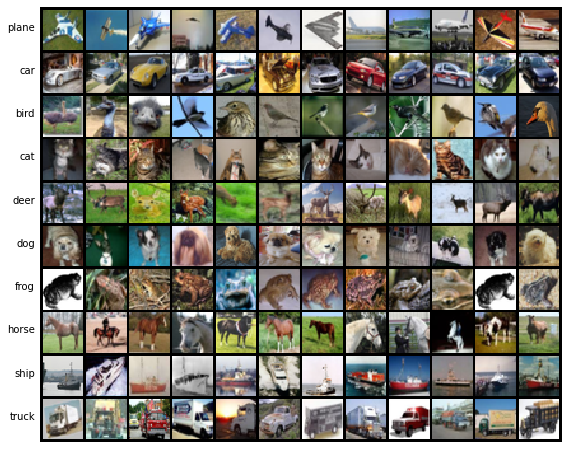

Train data shape:  torch.Size([47500, 3, 32, 32])
Train labels shape:  torch.Size([47500])
Validation data shape:  torch.Size([2500, 3, 32, 32])
Validation labels shape:  torch.Size([2500])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


In [ ]:
# Invoke the above function to get data.
data_dict = get_CIFAR10_data(visualize=True)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

## Linear layer: forward
Implementing the `Linear.forward` function.

In [ ]:
def linear_forward(x, w, b):
  """
  Computes the forward pass for an linear (fully-connected) layer.
  The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
  examples, where each example x[i] has shape (d_1, ..., d_k).
  Inputs:
  - x: A tensor containing input data, of shape (N, d_1, ..., d_k)
  - w: A tensor of weights, of shape (D, M)
  - b: A tensor of biases, of shape (M,)
  Returns a tuple of:
  - out: output, of shape (N, M)
  - cache: (x, w, b)
  """
  # need to reshape the input into rows.                                 
  out = x.flatten(start_dim=1).mm(w) + b
  cache = (x, w, b)
  return out, cache

Linear.forward = linear_forward

## Linear layer: backward
Manually Implementing the `Linear.backward` function.

In [ ]:
def linear_backward(dout, cache):
  """
  Computes the backward pass for an linear layer.
  Inputs:
  - dout: Upstream derivative, of shape (N, M)
  - cache: Tuple of:
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)
    - b: Biases, of shape (M,)
  Returns a tuple of:
  - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
  - dw: Gradient with respect to w, of shape (D, M)
  - db: Gradient with respect to b, of shape (M,)
  """
  x, w, b = cache
  # Implementing the linear backward pass.                                 
  n = x.shape
  dx = dout.mm(w.t()).reshape(n)
  dw = x.flatten(start_dim = 1).t().mm(dout)
  db = torch.sum(dout,0)
  return dx, dw, db

Linear.backward = linear_backward

## ReLU activation: forward
Manually implementing the forward pass for the ReLU activation function in the `ReLU.forward` function.


In [ ]:
def relu_forward(x):
  """
  Computes the forward pass for a layer of rectified linear units (ReLUs).
  Input:
  - x: Input; a tensor of any shape
  Returns a tuple of:
  - out: Output, a tensor of the same shape as x
  - cache: x
  """                               
  zero = torch.zeros_like(x)
  out = torch.max(zero,x)
  cache = x
  return out, cache

ReLU.forward = relu_forward

## ReLU activation: backward
Manually implementing the backward pass for the ReLU activation function.


In [ ]:
def relu_backward(dout, cache):
  """
  Computes the backward pass for a layer of rectified linear units (ReLUs).
  Input:
  - dout: Upstream derivatives, of any shape
  - cache: Input x, of same shape as dout
  Returns:
  - dx: Gradient with respect to x
  """
  mask = torch.zeros_like(x)
  mask[x>0] = 1
  dx = dout * mask
  return dx

ReLU.backward = relu_backward

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, linear layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, I defined a convenience layer.

This also shows how my layer abstraction allows me to implement new layers by composing existing layer implementations. This is a powerful mechanism for structuring deep learning code in a modular fashion.


In [ ]:
class Linear_ReLU(object):

  @staticmethod
  def forward(x, w, b):
    """
    Convenience layer that perorms an linear transform followed by a ReLU.

    Inputs:
    - x: Input to the linear layer
    - w, b: Weights for the linear layer
    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = Linear.forward(x, w, b)
    out, relu_cache = ReLU.forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the linear-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = ReLU.backward(dout, relu_cache)
    dx, dw, db = Linear.backward(da, fc_cache)
    return dx, dw, db

# Loss layers: Softmax and SVM


In [ ]:
def svm_loss(x, y):
  """
  Computes the loss and gradient using for multiclass SVM classification.
  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
    class for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C
  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  N = x.shape[0]
  correct_class_scores = x[torch.arange(N), y]
  margins = (x - correct_class_scores[:, None] + 1.0).clamp(min=0.)
  margins[torch.arange(N), y] = 0.
  loss = margins.sum() / N
  num_pos = (margins > 0).sum(dim=1)
  dx = torch.zeros_like(x)
  dx[margins > 0] = 1.
  dx[torch.arange(N), y] -= num_pos.to(dx.dtype)
  dx /= N
  return loss, dx


def softmax_loss(x, y):
  """
  Computes the loss and gradient for softmax classification.
  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
    class for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C
  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  shifted_logits = x - x.max(dim=1, keepdim=True).values
  Z = shifted_logits.exp().sum(dim=1, keepdim=True)
  log_probs = shifted_logits - Z.log()
  probs = log_probs.exp()
  N = x.shape[0]
  loss = (-1.0/ N) * log_probs[torch.arange(N), y].sum()
  dx = probs.clone()
  dx[torch.arange(N), y] -= 1
  dx /= N
  return loss, dx

# Two-layer network
Now that I have implemented modular versions of the necessary layers, I will implement the two layer network using these modular implementations.

In [ ]:
class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network with ReLU nonlinearity and
  softmax loss that uses a modular layer design. Assuming an input dimension
  of D, a hidden dimension of H, and perform classification over C classes.

  The learnable parameters of the model are stored in the dictionary
  self.params that maps parameter names to PyTorch tensors.
  """

  def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
         weight_scale=1e-3, reg=0.0, dtype=torch.float32, device='cpu'):
    """
    Initialize a new network.
    Inputs:
    - input_dim: An integer giving the size of the input
    - hidden_dim: An integer giving the size of the hidden layer
    - num_classes: An integer giving the number of classes to classify
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - reg: Scalar giving L2 regularization strength.
    - dtype: A torch data type object; all computations will be performed using
      this datatype. float is faster but less accurate
    - device: device to use for computation. 'cpu' or 'cuda'
    """
    self.params = {}
    self.reg = reg  
    # Weights are initialized from a Gaussian centered at 0.0 with              
    # standard deviation equal to weight_scale, and biases are          
    # initialized to zero.                   
    self.device = device
    self.params['W1'] = weight_scale * torch.randn(input_dim,hidden_dim,dtype=dtype,device=device)
    self.params['W2'] = weight_scale * torch.randn(hidden_dim,num_classes,dtype=dtype,device=device)
    self.params['b1'] = torch.zeros(hidden_dim,dtype=dtype,device=device)
    self.params['b2'] = torch.zeros(num_classes,dtype=dtype,device=device)


  def loss(self, X, y=None):
    """
    Compute loss and gradient for a minibatch of data.

    Inputs:
    - X: Tensor of input data of shape (N, d_1, ..., d_k)
    - y: int64 Tensor of labels, of shape (N,). y[i] gives the label for X[i].

    Returns:
    If y is None, then run a test-time forward pass of the model and return:
    - scores: Tensor of shape (N, C) giving classification scores, where
      scores[i, c] is the classification score for X[i] and class c.
    If y is not None, then run a training-time forward and backward pass and
    return a tuple of:
    - loss: Scalar value giving the loss
    - grads: Dictionary with the same keys as self.params, mapping parameter
      names to gradients of the loss with respect to those parameters.
    """            
    hidden, cache_first = Linear_ReLU.forward(X, self.params['W1'], self.params['b1'])
    scores, cache_second = Linear.forward(hidden,self.params['W2'], self.params['b2'])

    # If y is None then model in inference mode so just return scores
    if y is None:
      return scores

    loss, grads = 0, {}                
    loss, dout = softmax_loss(scores,y)
    # L2 regularization
    loss+= (torch.sum(self.params['W1'] ** 2) + torch.sum(self.params['W2'] **2)) * self.reg

    #backward pass
    dhidden, grads['W2'], grads['b2'] = Linear.backward(dout, cache_second)
    dx, grads['W1'], grads['b1'] = Linear_ReLU.backward(dhidden,cache_first)
    grads['W2'] += 2 * self.params['W2'] * self.reg
    grads['W1'] += 2 * self.params['W1'] * self.reg
    return loss, grads

In [ ]:
fix_random_seed(0)
model = TwoLayerNet(dtype=torch.float, device='cuda')

# Using a Solver instance to train a TwoLayerNet                                     
solver = Solver(model,data_dict,num_epochs = 20, device= 'cuda',optim_config={'learning_rate': 1e-1,},lr_decay=0.90)
solver.train()

(Time 0.01 sec; Iteration 1 / 9500) loss: 2.302592
(Epoch 0 / 20) train acc: 0.091000; val_acc: 0.113600
(Time 0.27 sec; Iteration 11 / 9500) loss: 2.302520
(Time 0.31 sec; Iteration 21 / 9500) loss: 2.302685
(Time 0.35 sec; Iteration 31 / 9500) loss: 2.298858
(Time 0.39 sec; Iteration 41 / 9500) loss: 2.301529
(Time 0.42 sec; Iteration 51 / 9500) loss: 2.292158
(Time 0.46 sec; Iteration 61 / 9500) loss: 2.272299
(Time 0.50 sec; Iteration 71 / 9500) loss: 2.249922
(Time 0.54 sec; Iteration 81 / 9500) loss: 2.201731
(Time 0.58 sec; Iteration 91 / 9500) loss: 2.216449
(Time 0.62 sec; Iteration 101 / 9500) loss: 2.229036
(Time 0.66 sec; Iteration 111 / 9500) loss: 2.158903
(Time 0.70 sec; Iteration 121 / 9500) loss: 2.082681
(Time 0.73 sec; Iteration 131 / 9500) loss: 2.119074
(Time 0.77 sec; Iteration 141 / 9500) loss: 2.098886
(Time 0.81 sec; Iteration 151 / 9500) loss: 1.970880
(Time 0.85 sec; Iteration 161 / 9500) loss: 2.046904
(Time 0.88 sec; Iteration 171 / 9500) loss: 1.954453
(Ti

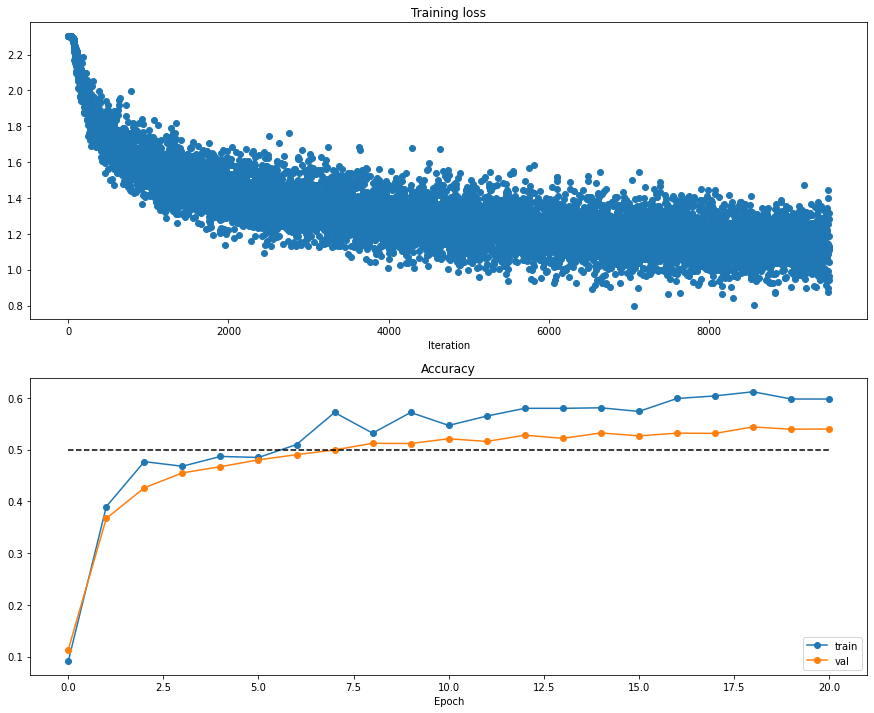

In [ ]:
# Visualizing training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next I will implement a fully-connected network with an arbitrary number of hidden layers and dropout.

In [ ]:
class FullyConnectedNet(object):
  """
  A fully-connected neural network with an arbitrary number of hidden layers,
  ReLU nonlinearities, and a softmax loss function.
  For a network with L layers, the architecture will be:

  {linear - relu - [dropout]} x (L - 1) - linear - softmax

  where dropout is optional, and the {...} block is repeated L - 1 times.
  """

  def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=0.0, reg=0.0, weight_scale=1e-2, seed=None,
               dtype=torch.float, device='cpu'):
    """
    Initializing a new FullyConnectedNet.

    Inputs:
    - hidden_dims: A list of integers giving the size of each hidden layer.
    - input_dim: An integer giving the size of the input.
    - num_classes: An integer giving the number of classes to classify.
    - dropout: Scalar between 0 and 1 giving the drop probability for networks
      with dropout. If dropout=0 then the network should not use dropout.
    - reg: Scalar giving L2 regularization strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - seed: If not None, then pass this random seed to the dropout layers. This
      will make the dropout layers deteriminstic.
    - dtype: A torch data type object; all computations will be performed using
      this datatype. float is faster but less accurate.
    - device: device to use for computation. 'cpu' or 'cuda'
    """
    self.use_dropout = dropout != 0
    self.reg = reg
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    self.params = {}
    # Weights are initialized from a normal distribution centered at 0 with standard       
    # deviation equal to weight_scale. Biases are initialized to zero.   
    self.params['W1'] = weight_scale * torch.randn(input_dim,hidden_dims[0],dtype=dtype,device=device)
    self.params['b1'] = torch.zeros(hidden_dims[0],dtype=dtype,device=device)
    for i in range(0,self.num_layers - 2):
        self.params['W'+str(i+2)] = weight_scale * torch.randn(hidden_dims[i],hidden_dims[i+1],dtype=dtype,device=device)
        self.params['b'+str(i+2)] = torch.zeros(hidden_dims[i+1],dtype=dtype,device=device)
    self.params['W'+str(self.num_layers)] = weight_scale * torch.randn(hidden_dims[-1],num_classes,dtype=dtype,device=device)
    self.params['b'+str(self.num_layers)] = torch.zeros(num_classes,dtype=dtype,device=device)
    # When using dropout I need to pass a dropout_param dictionary to each
    # dropout layer so that the layer knows the dropout probability and the mode
    # (train / test).
    self.dropout_param = {}
    if self.use_dropout:
      self.dropout_param = {'mode': 'train', 'p': dropout}
      if seed is not None:
        self.dropout_param['seed'] = seed


  def loss(self, X, y=None):
    """
    Computing loss and gradient for the fully-connected net.
    Input / output: Same as TwoLayerNet above.
    """
    X = X.to(self.dtype)
    mode = 'test' if y is None else 'train'

    # Setting train/test mode for batchnorm params and dropout param since they
    # behave differently during training and testing.
    if self.use_dropout:
      self.dropout_param['mode'] = mode                                                  
    hidden_output = X
    caches = []
    drop_cache = []
    for i in range(self.num_layers - 1):
        w = self.params['W'+str(i+1)]
        b = self.params['b'+str(i+1)]

        hidden_output, cache = Linear_ReLU.forward(hidden_output, w, b)
        caches.append(cache)
        if self.use_dropout:
            hidden_output, dropped = Dropout.forward(hidden_output,self.dropout_param)
            drop_cache.append(dropped)
        
    w = self.params['W'+str(self.num_layers)]
    b = self.params['b'+str(self.num_layers)]
    hidden_output, cache = Linear.forward(hidden_output,w,b)
    caches.append(cache)
    scores = hidden_output
    # If test mode return early
    if mode == 'test':
      return scores

    loss, grads = 0.0, {}

    # Implementing the backward pass for the fully-connected net           
    loss, dout = softmax_loss(scores,y)
    # Regularization
    for i in range(self.num_layers):
        w = self.params['W'+str(i+1)]
        loss+= torch.sum(w**2) * self.reg
    # Last layer
    dout, dw, db = Linear.backward(dout,caches.pop())
    grads['W'+str(self.num_layers)] = dw + 2 * self.reg * self.params['W'+str(self.num_layers)]
    grads['b'+str(self.num_layers)] = db

    for i in range(self.num_layers - 1):
        if self.use_dropout:
            dout = Dropout.backward(dout,drop_cache.pop())
        dout, dw, db = Linear_ReLU.backward(dout, caches.pop())
        grads['W'+str(self.num_layers - i - 1)] = dw + 2 * self.reg * self.params['W'+ str(self.num_layers - i - 1)]
        grads['b'+str(self.num_layers - i - 1)] = db

    return loss, grads

As sanity check, I make sure that I can overfit a small dataset of 50 images. First I will try a three-layer network with 100 units in each hidden layer.

(Time 0.00 sec; Iteration 1 / 40) loss: 2.429933
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.121200
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.124400
(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.149600
(Epoch 3 / 20) train acc: 0.640000; val_acc: 0.159600
(Epoch 4 / 20) train acc: 0.740000; val_acc: 0.167600
(Epoch 5 / 20) train acc: 0.800000; val_acc: 0.169200
(Time 0.13 sec; Iteration 11 / 40) loss: 1.083227
(Epoch 6 / 20) train acc: 0.860000; val_acc: 0.170400
(Epoch 7 / 20) train acc: 0.880000; val_acc: 0.181600
(Epoch 8 / 20) train acc: 0.900000; val_acc: 0.170800
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.167200
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.169200
(Time 0.23 sec; Iteration 21 / 40) loss: 0.586986
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.180800
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.177600
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.178800
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.176000
(Epoch 15 / 20) train acc: 0.980000;

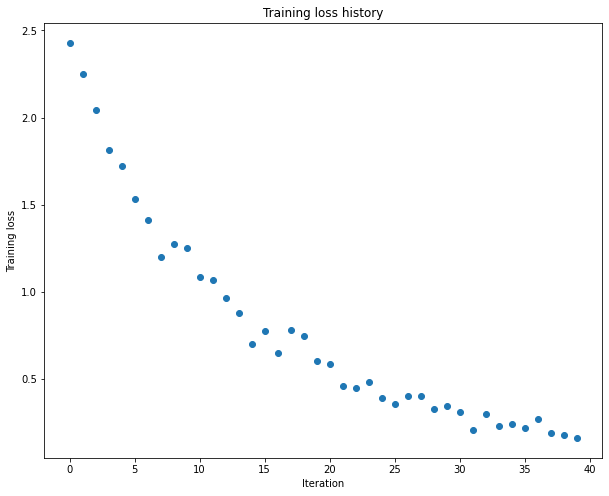

In [ ]:
# Using a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
fix_random_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

weight_scale = 1e-1  # Harcoded
learning_rate = 1e-1 # Harcoded                                       
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, **to_float_cuda)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now I will try to use a five-layer network with 100 units on each layer to overfit 50 training examples.

(Time 0.01 sec; Iteration 1 / 40) loss: 2.369859
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.115600
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.130800
(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.125600
(Epoch 3 / 20) train acc: 0.540000; val_acc: 0.132000
(Epoch 4 / 20) train acc: 0.620000; val_acc: 0.157600
(Epoch 5 / 20) train acc: 0.800000; val_acc: 0.147600
(Time 0.16 sec; Iteration 11 / 40) loss: 1.148560
(Epoch 6 / 20) train acc: 0.780000; val_acc: 0.143200
(Epoch 7 / 20) train acc: 0.520000; val_acc: 0.138000
(Epoch 8 / 20) train acc: 0.760000; val_acc: 0.156800
(Epoch 9 / 20) train acc: 0.760000; val_acc: 0.156800
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.171600
(Time 0.30 sec; Iteration 21 / 40) loss: 0.445433
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.183200
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.175200
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.187200
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.178800
(Epoch 15 / 20) train acc: 1.000000;

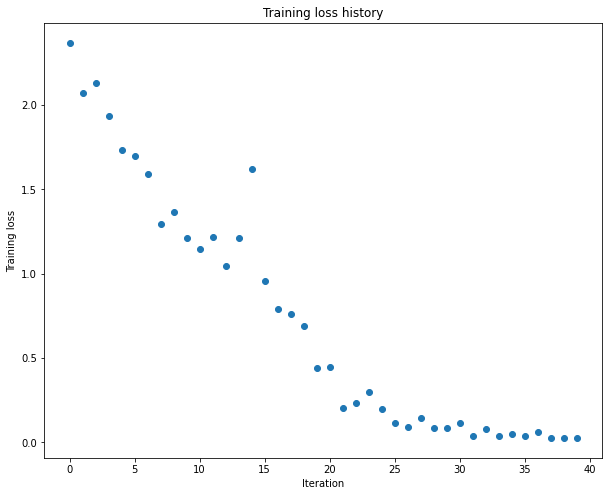

In [ ]:
# Using a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
fix_random_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

learning_rate = 2e-1 # Harcoded
weight_scale = 1e-1 # Harcoded                                    
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, **to_float_cuda)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Update rules
So far I have used vanilla stochastic gradient descent (SGD) as my update rule. More sophisticated update rules can make it easier to train deep networks. I will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent.
I will implement various first-order update rules that are commonly used
for training neural networks.


In [ ]:
def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.
    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config

Now I will implement the SGD+Momentum update rule using the same interface:

In [ ]:
def sgd_momentum(w, dw, config=None):
  """
  Performs stochastic gradient descent with momentum.
  config format:
  - learning_rate: Scalar learning rate.
  - momentum: Scalar between 0 and 1 giving the momentum value.
    Setting momentum = 0 reduces to sgd.
  - velocity: A numpy array of the same shape as w and dw used to store a
    moving average of the gradients.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  config.setdefault('momentum', 0.9)
  v = config.get('velocity', torch.zeros_like(w))     
  mu = config['momentum']
  lr = config['learning_rate']
  v = mu * v - lr * dw
  next_w = w + v
  
  config['velocity'] = v

  return next_w, config

Now I will train a six-layer network with both SGD and SGD+momentum.The SGD+momentum update rule converges faster.

running with  sgd
(Time 0.01 sec; Iteration 1 / 200) loss: 2.301954
(Epoch 0 / 5) train acc: 0.097000; val_acc: 0.098400
(Epoch 1 / 5) train acc: 0.098000; val_acc: 0.093600
(Epoch 2 / 5) train acc: 0.094000; val_acc: 0.093600
(Epoch 3 / 5) train acc: 0.117000; val_acc: 0.093600
(Epoch 4 / 5) train acc: 0.110000; val_acc: 0.096800
(Epoch 5 / 5) train acc: 0.092000; val_acc: 0.093600

running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302752
(Epoch 0 / 5) train acc: 0.104000; val_acc: 0.096800
(Epoch 1 / 5) train acc: 0.112000; val_acc: 0.096400
(Epoch 2 / 5) train acc: 0.186000; val_acc: 0.180000
(Epoch 3 / 5) train acc: 0.208000; val_acc: 0.208000
(Epoch 4 / 5) train acc: 0.253000; val_acc: 0.231200
(Epoch 5 / 5) train acc: 0.249000; val_acc: 0.244800



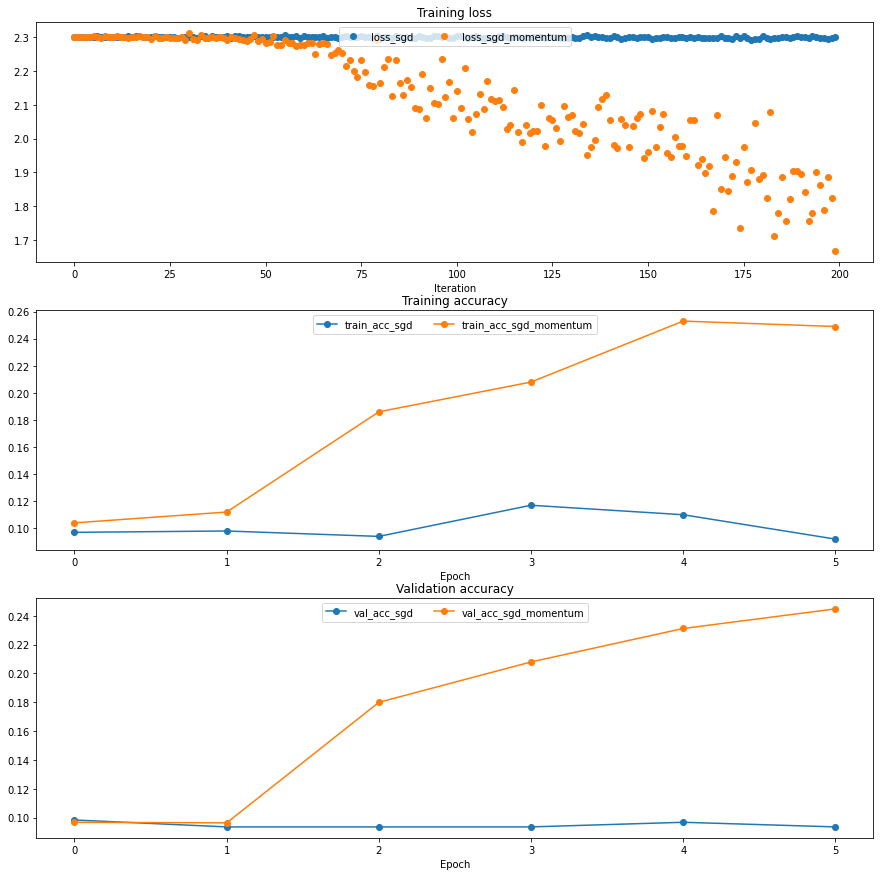

In [ ]:
num_train = 4000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}

for update_rule_name, update_rule_fn in [('sgd', sgd), ('sgd_momentum', sgd_momentum)]:
  print('running with ', update_rule_name)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2,
                            **to_float_cuda)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': 5e-2,
                  },
                  print_every=1000,
                  verbose=True,
                  device='cuda')
  solvers[update_rule_name] = solver
  solver.train()
  print()
  
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in solvers.items():
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
plt.legend(loc='upper center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)
plt.legend(loc='upper center', ncol=4)

  
plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
plt.legend(loc='upper center', ncol=4)

plt.gcf().set_size_inches(15, 15)
plt.show()

## RMSProp
RMSProp is an update rule that set per-parameter learning rates by using a running average of the second moments of gradients.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

In [ ]:
def rmsprop(w, dw, config=None):
  """
  Uses the RMSProp update rule, which uses a moving average of squared
  gradient values to set adaptive per-parameter learning rates.
  config format:
  - learning_rate: Scalar learning rate.
  - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
    gradient cache.
  - epsilon: Small scalar used for smoothing to avoid dividing by zero.
  - cache: Moving average of second moments of gradients.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  config.setdefault('decay_rate', 0.99)
  config.setdefault('epsilon', 1e-8)
  config.setdefault('cache', torch.zeros_like(w))                                                        
  lr, dr, eps, c =  config['learning_rate'],\
                      config['decay_rate'],\
                        config['epsilon'],\
                          config['cache']
  
  c = dr * c + (1 - dr) * (dw * dw)
  next_w = w - lr * dw / (torch.sqrt(c) + eps)
  config['cache'] = c

  return next_w, config

## Adam
Adam extends RMSprop with a first-order gradient cache similar to momentum, and a bias correction mechanism to prevent large steps at the start of optimization. Adam is one of the most commonly used update rules used in practice for training deep neural networks.

I will implement the _complete_ Adam update rule (with the bias correction mechanism), not the initial simplified version . 

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
def adam(w, dw, config=None):
  """
  Uses the Adam update rule, which incorporates moving averages of both the
  gradient and its square and a bias correction term.
  config format:
  - learning_rate: Scalar learning rate.
  - beta1: Decay rate for moving average of first moment of gradient.
  - beta2: Decay rate for moving average of second moment of gradient.
  - epsilon: Small scalar used for smoothing to avoid dividing by zero.
  - m: Moving average of gradient.
  - v: Moving average of squared gradient.
  - t: Iteration number.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-3)
  config.setdefault('beta1', 0.9)
  config.setdefault('beta2', 0.999)
  config.setdefault('epsilon', 1e-8)
  config.setdefault('m', torch.zeros_like(w))
  config.setdefault('v', torch.zeros_like(w))
  config.setdefault('t', 0)
                                              
  lr, b1, b2, eps = config['learning_rate'], config['beta1'], config['beta2'], config['epsilon']
  m, v, t = config['m'], config['v'], config['t']
  t += 1

  m = b1 * m + (1-b1) * dw
  mt = m / (1-b1**t)
  v = b2 * v + (1-b2) * (dw ** 2)
  vt = v / (1-b2**t)
  next_w = w - lr * mt / (torch.sqrt(vt) + eps)

  config['m'], config['v'], config['t'] =  m, v, t

  return next_w, config

Once I have finished my RMSProp and Adam implementations, I will train a pair of deep networks using these new update rules:

running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.301954
(Epoch 0 / 5) train acc: 0.121000; val_acc: 0.112400
(Epoch 1 / 5) train acc: 0.284000; val_acc: 0.271600
(Epoch 2 / 5) train acc: 0.338000; val_acc: 0.287200
(Epoch 3 / 5) train acc: 0.373000; val_acc: 0.323600
(Epoch 4 / 5) train acc: 0.406000; val_acc: 0.345600
(Epoch 5 / 5) train acc: 0.443000; val_acc: 0.359600

running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302752
(Epoch 0 / 5) train acc: 0.134000; val_acc: 0.126400
(Epoch 1 / 5) train acc: 0.245000; val_acc: 0.234400
(Epoch 2 / 5) train acc: 0.243000; val_acc: 0.231600
(Epoch 3 / 5) train acc: 0.252000; val_acc: 0.257600
(Epoch 4 / 5) train acc: 0.281000; val_acc: 0.270400
(Epoch 5 / 5) train acc: 0.277000; val_acc: 0.276000



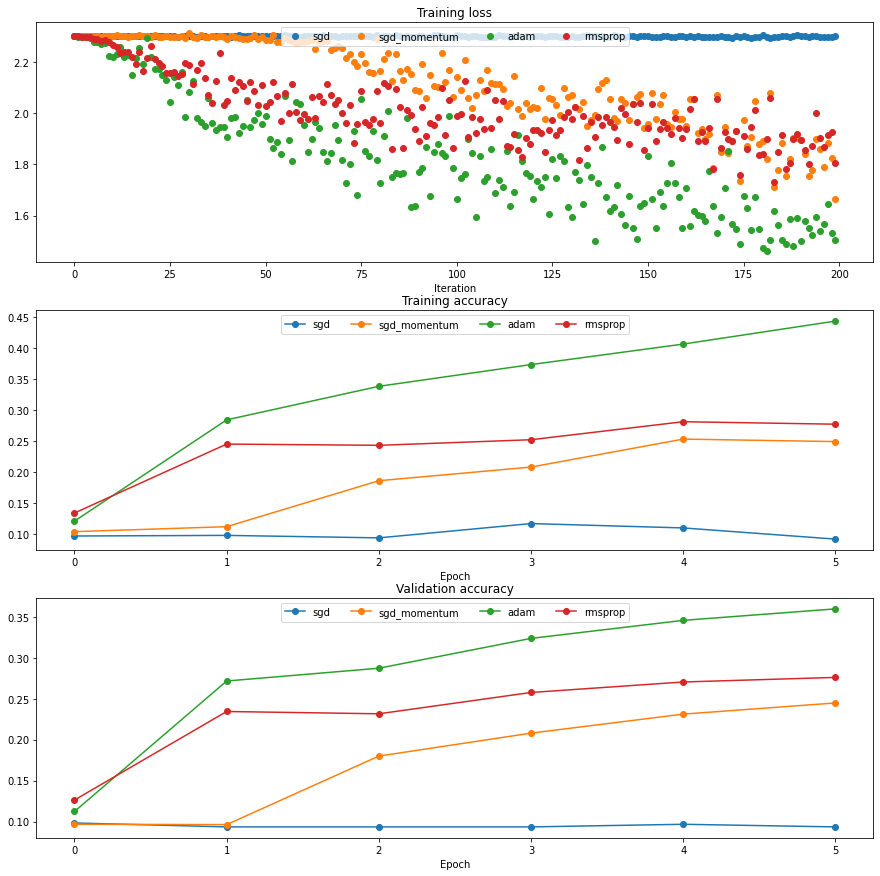

In [ ]:
for update_rule_name, update_rule_fn, learning_rate in [('adam', adam, 1e-3), ('rmsprop', rmsprop, 1e-4)]:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, device='cuda')

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=1000,
                  verbose=True, device='cuda')
  solvers[update_rule_name] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.loss_history, 'o', label=update_rule)
plt.legend(loc='upper center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.train_acc_history, '-o', label=update_rule)
plt.legend(loc='upper center', ncol=4)

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
plt.legend(loc='upper center', ncol=4)

plt.gcf().set_size_inches(15, 15)
plt.show()

# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. Next I will implement a dropout layer and modify my fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

## Dropout: forward
Implementing the forward pass for dropout. Since dropout behaves differently during training and testing, I need to implement the operation for both modes.


In [ ]:
def dropout_forward(x, dropout_param):
  """
  Performs the forward pass for (inverted) dropout.
  Inputs:
  - x: Input data: tensor of any shape
  - dropout_param: A dictionary with the following keys:
    - p: Dropout parameter. I *drop* each neuron output with probability p.
    - mode: 'test' or 'train'. If the mode is train, then perform dropout;
    if the mode is test, then just return the input.
    - seed: Seed for the random number generator. Passing seed makes this
    function deterministic.
  Outputs:
  - out: Tensor of the same shape as x.
  - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
    mask that was used to multiply the input; in test mode, mask is None.
  I will implement **inverted** dropout, not the vanilla version of dropout.
  See http://cs231n.github.io/neural-networks-2/#reg for more details.
  Also p is the probability of **dropping** a neuron
  output; this might be contrary to some sources, where it is referred to
  as the probability of keeping a neuron output.
  """
  p, mode = dropout_param['p'], dropout_param['mode']
  if 'seed' in dropout_param:
    torch.manual_seed(dropout_param['seed'])

  if mode == 'train':                           
    mask = (torch.rand(*x.shape,dtype=x.dtype,device=x.device) < (1-p))
    out = mask * x
  elif mode == 'test':       
    out = x

  cache = (dropout_param, mask)

  return out, cache

Dropout.forward = dropout_forward

Next I will test my dropout implementation. The mean of the output should be approximately the same during training and testing. During training the number of outputs set to zero should be approximately equal to the drop probability `p`, and during testing no outputs should be set to zero.

In [ ]:
fix_random_seed(0)
x = torch.randn(500, 500, **to_double_cuda) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = Dropout.forward(x, {'mode': 'train', 'p': p})
  out_test, _ = Dropout.forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean().item())
  print('Mean of train-time output: ', out.mean().item())
  print('Mean of test-time output: ', out_test.mean().item())
  print('Fraction of train-time output set to zero: ', (out == 0).type(torch.float32).mean().item())
  print('Fraction of test-time output set to zero: ', (out_test == 0).type(torch.float32).mean().item())
  print()

Running tests with p =  0.25
Mean of input:  9.9994600386708
Mean of train-time output:  7.500884000708023
Mean of test-time output:  9.9994600386708
Fraction of train-time output set to zero:  0.24992400407791138
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  9.9994600386708
Mean of train-time output:  6.00751909529313
Mean of test-time output:  9.9994600386708
Fraction of train-time output set to zero:  0.3992919921875
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  9.9994600386708
Mean of train-time output:  2.9790337733514893
Mean of test-time output:  9.9994600386708
Fraction of train-time output set to zero:  0.7018679976463318
Fraction of test-time output set to zero:  0.0



## Dropout: backward
Implementation the backward pass for dropout.

In [ ]:
def dropout_backward(dout, cache):
  """
  Perform the backward pass for (inverted) dropout.
  Inputs:
  - dout: Upstream derivatives, of any shape
  - cache: (dropout_param, mask) from Dropout.forward.
  """
  dropout_param, mask = cache
  mode = dropout_param['mode']

  if mode == 'train':     
    dx = dout * mask
  elif mode == 'test':
    dx = dout
  return dx

Dropout.backward = dropout_backward

# Fully-connected nets with dropout
Modification of [my implementation](#scrollTo=7p-goSyucyZH) of `FullyConnectedNet` to use dropout. Specifically, if the constructor of the network receives a value that is not 0 for the `dropout` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity.


In [ ]:
fix_random_seed(0)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, **to_double_cuda)
y = torch.randint(C, size=(N,), **to_long_cuda)

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dropout=dropout,
                            seed=0, **to_double_cuda)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())
  
  # Relative errors should be around e-5 or less.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  0
Initial loss:  2.3053575717037686
W1 relative error: 7.62e-06
W2 relative error: 3.47e-07
W3 relative error: 1.39e-07
b1 relative error: 4.20e-07
b2 relative error: 3.76e-09
b3 relative error: 2.34e-10

Running check with dropout =  0.25
Initial loss:  2.3083860636196043
W1 relative error: 1.24e-06
W2 relative error: 6.99e-07
W3 relative error: 9.23e-07
b1 relative error: 1.20e-08
b2 relative error: 1.59e-09
b3 relative error: 3.14e-10

Running check with dropout =  0.5
Initial loss:  2.3029412290508864
W1 relative error: 4.19e-07
W2 relative error: 1.10e-07
W3 relative error: 6.46e-07
b1 relative error: 1.02e-08
b2 relative error: 3.20e+06
b3 relative error: 1.86e-10



## Regularization experiment
To show of the way that dropout can regularize a neural network, I will train three different two-layer networks:

1. Hidden size 256, dropout = 0
2. Hidden size 512, dropout = 0
3. Hidden size 512, dropout = 0.5

I will then visualize the training and validation accuracies of these three networks.

In [ ]:
# Train two identical nets, one with dropout and one without
fix_random_seed(0)
num_train = 20000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}
dropout_choices = [0, 0, 0.5]
width_choices = [256, 512, 512]
for dropout, width in zip(dropout_choices, width_choices):
# for dropout in dropout_choices:
  model = FullyConnectedNet([width], dropout=dropout, **to_float_cuda)
  print('Training a model with dropout=%.2f and width=%d' % (dropout, width))

  solver = Solver(model, small_data,
                  num_epochs=100, batch_size=512,
                  update_rule=adam,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  print_every=100000, print_acc_every=10,
                  verbose=True, device='cuda')
  solver.train()
  solvers[(dropout, width)] = solver
  print()

Training a model with dropout=0.00 and width=256
(Time 0.01 sec; Iteration 1 / 3900) loss: 2.303838
(Epoch 0 / 100) train acc: 0.233000; val_acc: 0.224000
(Epoch 10 / 100) train acc: 0.718000; val_acc: 0.486800
(Epoch 20 / 100) train acc: 0.857000; val_acc: 0.465600
(Epoch 30 / 100) train acc: 0.932000; val_acc: 0.471200
(Epoch 40 / 100) train acc: 0.933000; val_acc: 0.472000
(Epoch 50 / 100) train acc: 0.975000; val_acc: 0.464000
(Epoch 60 / 100) train acc: 0.929000; val_acc: 0.467600
(Epoch 70 / 100) train acc: 0.983000; val_acc: 0.468800
(Epoch 80 / 100) train acc: 0.977000; val_acc: 0.464400
(Epoch 90 / 100) train acc: 0.949000; val_acc: 0.465600
(Epoch 100 / 100) train acc: 0.995000; val_acc: 0.468800

Training a model with dropout=0.00 and width=512
(Time 0.01 sec; Iteration 1 / 3900) loss: 2.304440
(Epoch 0 / 100) train acc: 0.233000; val_acc: 0.250800
(Epoch 10 / 100) train acc: 0.745000; val_acc: 0.489600
(Epoch 20 / 100) train acc: 0.894000; val_acc: 0.485200
(Epoch 30 / 100)

If everything worked as expected, I should see that the network with dropout has lower training accuracies than the networks without dropout, but that it achieves higher validation accuracies.

Also a network with width 512 and dropout 0.5 achieves higher validation accuracies than a network with width 256 and no dropout. This demonstrates that reducing the model size is not generally an effective regularization strategy -- it's often better to use a larger model with explicit regularization.

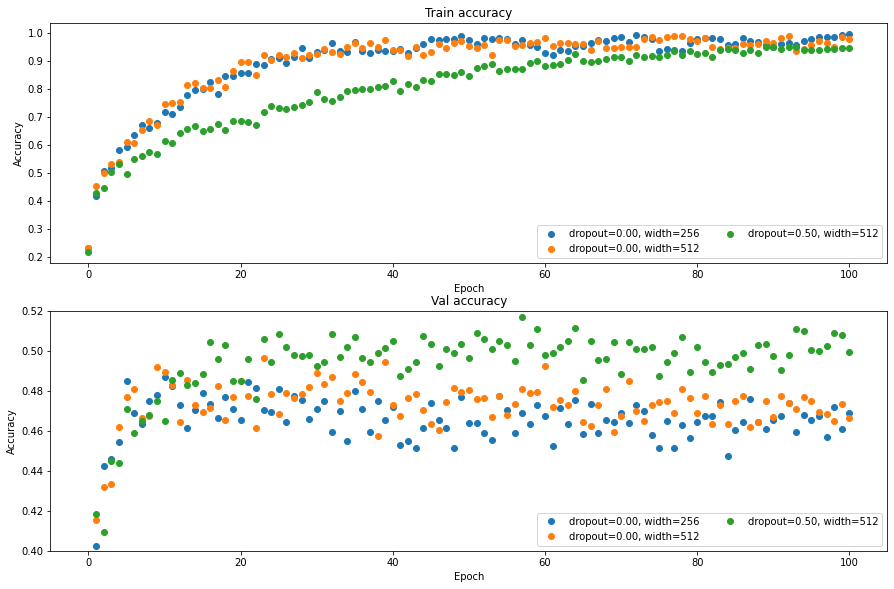

In [ ]:
plt.subplot(3, 1, 1)
for (dropout, width), solver in solvers.items():
  train_acc = solver.train_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(train_acc, 'o', label=label)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for (dropout, width), solver in solvers.items():
  val_acc = solver.val_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(val_acc, 'o', label=label)
plt.ylim(0.4, 0.52)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()